In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mplt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.core.interactiveshell import InteractiveShell
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import seaborn as sns
import math
import gc
import ipaddress
from urllib.parse import urlparse
from tldextract import extract
from sklearn.metrics import confusion_matrix

import sys
from pathlib import Path
d = Path().resolve().parent.parent
sys.path.insert(0, str(d))
import util.utils as utils
import util.plot_utils as plot_utils

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb

np.set_printoptions(threshold=np.nan)



plt.rcParams["figure.figsize"] = (12,4)

from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score


InteractiveShell.ast_node_interactivity = "all"

from sklearn.utils import resample

In [2]:
project_name="safe-driver"
def get_file_location(filename):
    return "../data/%s/%s" % (project_name,filename)

In [3]:
df = pd.read_csv("../data/%s/%s" % (project_name,"train.csv"),low_memory=False)
df_test = pd.read_csv("../data/%s/%s" % (project_name,"test.csv"),low_memory=False)
gc.collect()

92

In [4]:
all_features = [
 'ps_ind_01',
 'ps_ind_02_cat',
 'ps_ind_03',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_14',
 'ps_ind_15',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15',
 'ps_calc_01',
 'ps_calc_02',
 'ps_calc_03',
 'ps_calc_04',
 'ps_calc_05',
 'ps_calc_06',
 'ps_calc_07',
 'ps_calc_08',
 'ps_calc_09',
 'ps_calc_10',
 'ps_calc_11',
 'ps_calc_12',
 'ps_calc_13',
 'ps_calc_14',
 'ps_calc_15_bin',
 'ps_calc_16_bin',
 'ps_calc_17_bin',
 'ps_calc_18_bin',
 'ps_calc_19_bin',
 'ps_calc_20_bin']

output_column = 'target'
features = all_features

In [20]:
df_majority = df[df[output_column]==0]
df_minority = df[df[output_column]==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=273518,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled[output_column].value_counts()

0    573518
1    273518
Name: target, dtype: int64

In [21]:
# No benefits from up sampling
gc.collect()
X = df[features].values
# y = np.log10(df_train[output_column].values + 1)
# X = df_upsampled[features].values
# y = df_upsampled[output_column].values
y = df[output_column].values

2986

In [15]:
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]


In [22]:
xgc = XGBClassifier(max_depth=12, learning_rate=0.7,booster='dart',n_estimators=200,n_jobs=40,missing=-1)
xgc.fit(X, y.ravel())
gc.collect()

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.7, max_delta_step=0,
       max_depth=12, min_child_weight=1, missing=-1, n_estimators=200,
       n_jobs=40, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

319

In [23]:
def xgc_pred(X):
    return xgc.predict_proba(X)[:,1:2].flatten()

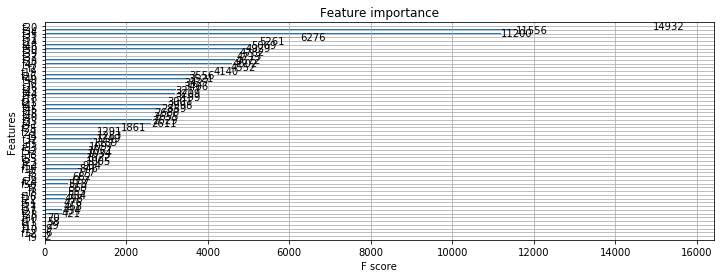

(57, 2)


,feature,importance
20,ps_reg_03,9.930701
34,ps_car_13,7.685452
35,ps_car_14,7.448690
31,ps_car_11_cat,4.173927
14,ps_ind_15,3.498889
46,ps_calc_10,3.371197
50,ps_calc_14,3.278089
39,ps_calc_03,3.180325
37,ps_calc_01,3.134435
38,ps_calc_02,3.107168


,feature,importance
20,ps_reg_03,9.930701
34,ps_car_13,7.685452
35,ps_car_14,7.448690
31,ps_car_11_cat,4.173927
14,ps_ind_15,3.498889
46,ps_calc_10,3.371197
50,ps_calc_14,3.278089
39,ps_calc_03,3.180325
37,ps_calc_01,3.134435
38,ps_calc_02,3.107168


In [24]:
def plot_importance(model,df,features):
    from xgboost import plot_importance
    plot_importance(model)
    plt.show()
    fi=model.feature_importances_

    fn=df[features].columns.values

    df_i=pd.DataFrame({"feature":fn,"importance":fi})
    df_i["importance"] = df_i["importance"]*100
    print(df_i.shape)
    return df_i.sort_values("importance",ascending=False)

imp=plot_importance(xgc,df,features)
imp.head(10)
imp

In [25]:

gc.collect()
def predict_and_store(model,filename):
    X_t = df_test[features].values
    y_t = model(X_t)
#     my_solution = pd.DataFrame(y_t, ids, columns = [output_column])
    my_solution = pd.DataFrame({"id":df_test["id"],"target":y_t})
#     my_solution[output_column] = my_solution[output_column].round(3)

    print(my_solution.shape)
#     my_solution.to_csv(filename, index_label = ["ID"])
    my_solution.to_csv(filename,index=False,columns=["id","target"])
    
predict_and_store(xgc_pred,"results.csv")

11005

(892816, 2)
